<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plot_keras_history import show_history, plot_history

# Traitement images
from matplotlib.image import imread
import time
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from keras.applications import InceptionResNetV2, DenseNet201, EfficientNetB7
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionresnetv2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet201
from PIL import Image as PilImage
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ML
#from sklearn import cluster, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score

# perso
from Deveau_Estelle_4_IMG_func_042024 import *

In [2]:
print("Version de TensorFlow installée : ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Version de TensorFlow installée :  2.16.1
Num GPUs Available:  0


## Data

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_txt_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'model_densenet201_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_ResNet50_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'standard.png',
 'standard2.png',
 'standard3.png',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__']

In [4]:
os.listdir("data/Cleaned/")

['data.csv']

In [5]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [6]:
data = pd.read_csv(path + filename)

In [7]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Exploration des données

## Quick tour

In [8]:
data.head()

uniq_id product_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [9]:
data.shape

(1050, 3)

In [10]:
data.dtypes.value_counts()

object    3
Name: count, dtype: int64

In [11]:
data.nunique()

uniq_id             1050
product_category       7
description         1050
dtype: int64

In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 0.0 %


In [13]:
# Liste de toutes les colonnes à conserver
cols_to_keep = ['uniq_id', 'product_category']

In [14]:
df = data[cols_to_keep]

In [15]:
df.head(5)

uniq_id product_category
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing

In [16]:
print("Valeurs uniques pour product_category dans df:", df['product_category'].unique())

Valeurs uniques pour product_category dans df: ['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


## Exemples d'images

In [17]:
def get_images_for_category(category, num_images=3):
    """Récupère les noms de fichiers des images pour une catégorie donnée."""
    category_ids = df[df['product_category'] == category]['uniq_id']
    category_images = [f"{id}.jpg" for id in category_ids if f"{id}.jpg" in list_photos]
    return category_images[:num_images]

Catégorie : Home Furnishing


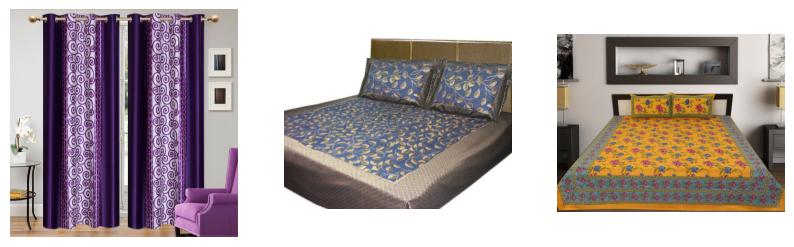

Catégorie : Baby Care


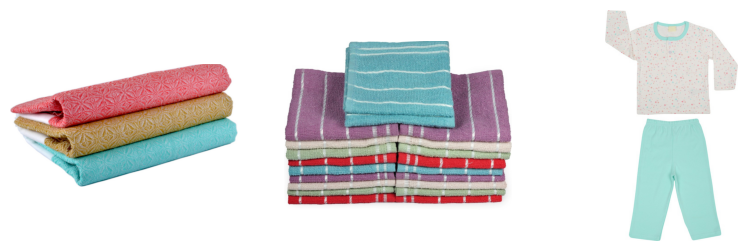

Catégorie : Watches


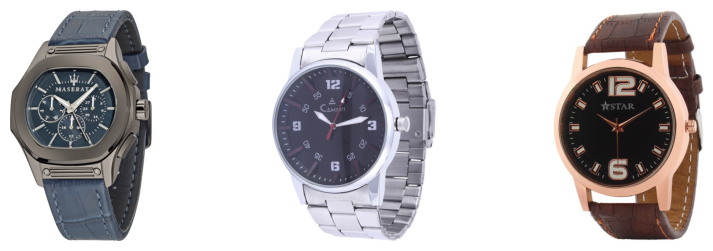

Catégorie : Home Decor & Festive Needs


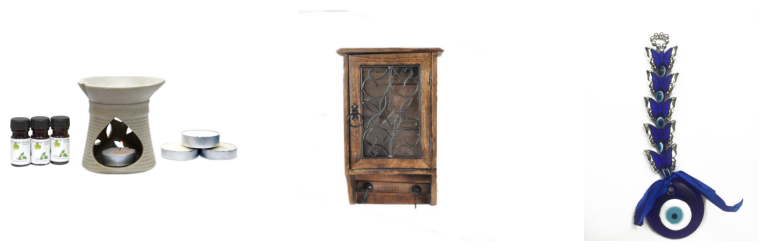

Catégorie : Kitchen & Dining


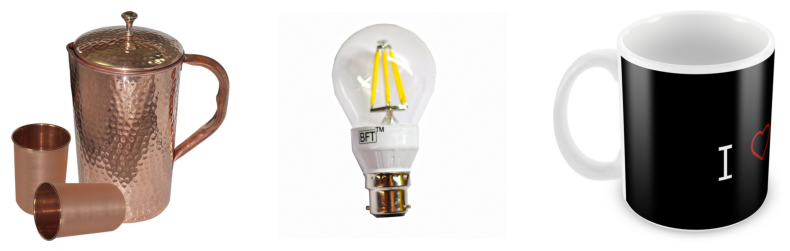

Catégorie : Beauty and Personal Care


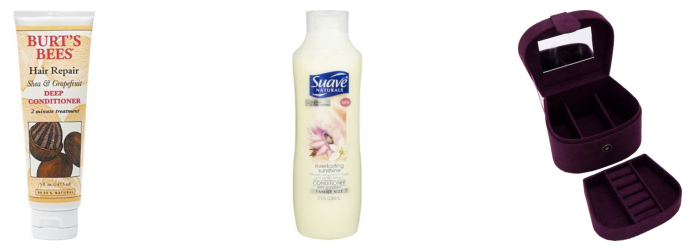

Catégorie : Computers


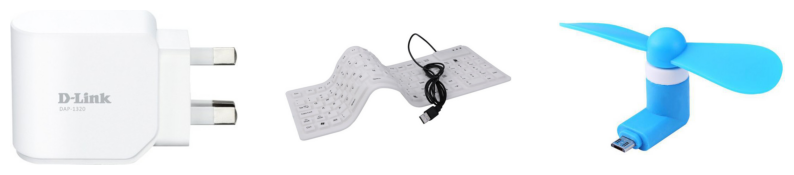

In [18]:
# Affichage des images
for category in df['product_category'].unique():
    print(f"Catégorie : {category}")
    category_images = get_images_for_category(category, 3)
    plt.figure(figsize=(10, 3)) 
    for i, image_name in enumerate(category_images):
        plt.subplot(1, 3, i+1)  
        filename = os.path.join(path, image_name)
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off') 
    plt.show()

# Etude de faisabilité

## Pré-traitements des Images avec SIFT

### Détermination des descripteurs

#### Sur une image

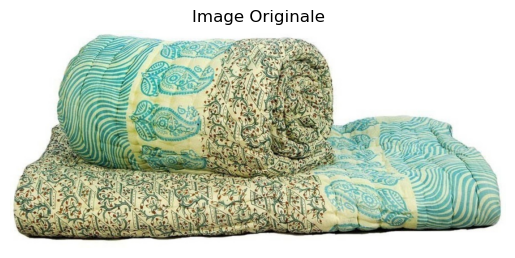

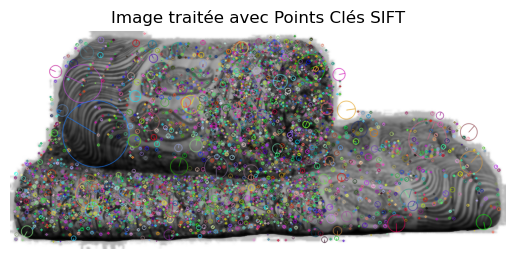

Descripteurs :  (3946, 128)
[[ 40.   2.   2. ...   0.   0.   1.]
 [134.  16.   0. ...   0.   4.   3.]
 [ 44.  91.   8. ...   0.   0.   4.]
 ...
 [  7.   5.  37. ...   0.   1.   6.]
 [ 17.   0.   0. ...   0.   0.   2.]
 [132.  81.   0. ...   0.   0.   1.]]


In [19]:
# Chemin de l'image
image_path = path + list_photos[1000]
original_image = cv2.imread(image_path)
plt_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.title("Image Originale")
plt.imshow(plt_image)
plt.axis('off')
plt.show()

# Traitement de l'image avec la fonction process_image
keypoints, descriptors, processed_image = process_image(image_path)

# Affichage des points clés sur l'image
if descriptors is not None:
    display_keypoints(processed_image, keypoints, "Image traitée avec Points Clés SIFT")
    print("Descripteurs : ", descriptors.shape)
    print(descriptors)
else:
    print("Aucun descripteur trouvé.")

#### Sur chaque image

In [20]:
# Initialisation du temps
temps1 = time.time()

image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

sift_keypoints_by_img, sift_keypoints_all = process_images_concurrently(image_paths)

duration1 = time.time() - temps1

print("Dimensions des descripteurs par image :", sift_keypoints_by_img.shape)
print("Nombre total de descripteurs :", sift_keypoints_all.shape)
print("Temps de traitement des descripteurs SIFT : ", "{:.2f}".format(duration1), "secondes")

Dimensions des descripteurs par image : (1050,)
Nombre total de descripteurs : (2961542, 128)
Temps de traitement des descripteurs SIFT :  103.47 secondes


### Création des clusters de descripteurs

In [21]:
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42, n_init=10)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

Nombre de clusters estimés :  1721
Création de 1721 clusters de descripteurs ...
Temps de traitement kmeans :  90.71 secondes


### Création des features des images

In [22]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de traitement kmeans :  51.44 secondes


### Réduction de dimension

#### ACP

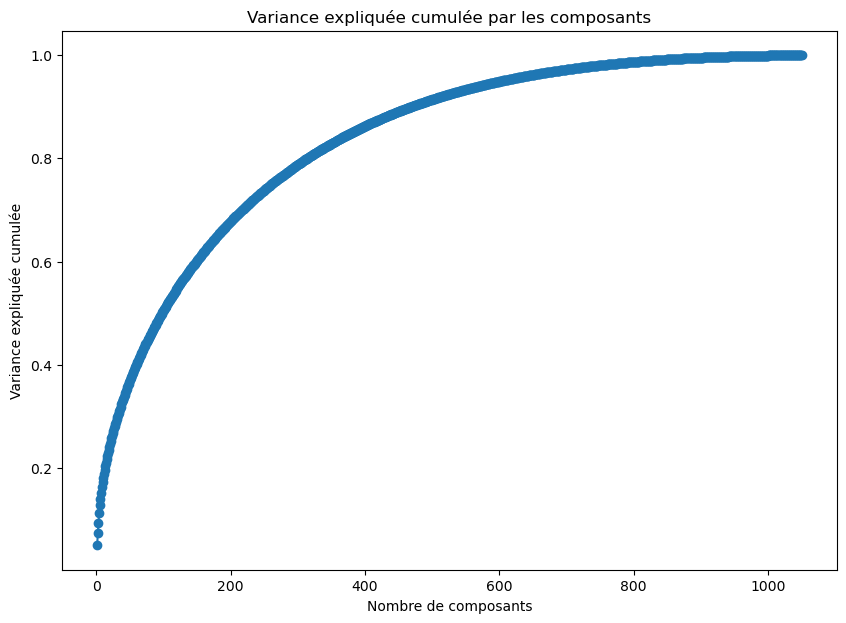

In [23]:
# Création de l'ACP
pca = PCA()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(im_features)

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [24]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 830


In [25]:
# PCA
pca = PCA(n_components=n_components_99, svd_solver='randomized', random_state=42)
reduced_im_features = pca.fit_transform(features_scaled)

#### T-SNE

In [26]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

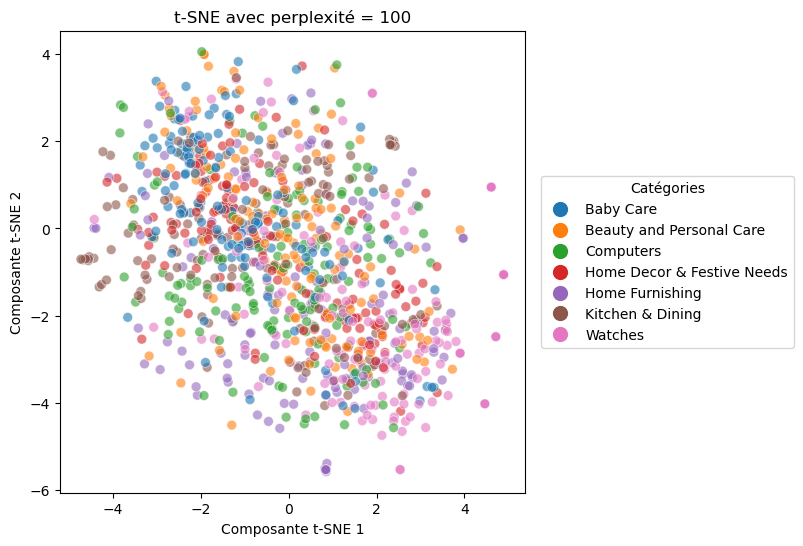

In [27]:
plot_tsne(reduced_im_features, categories_encoded, category_names, 100)

In [28]:
tsne = TSNE(n_components=2, verbose=0, perplexity=100, random_state=42)
tsne_reduced_im_features = tsne.fit_transform(reduced_im_features)

## Pré-traitement des images avec CNN

### Modèle basique

In [ ]:
def build_basic_model(input_shape=(64, 64, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(7, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Modèle Intermédiaire

In [ ]:
def build_intermediate_model(input_shape=(64, 64, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Comparaison avec des Modèles avancés

In [29]:
# Chargement des modèles
models = {
    'Basic_Model': (build_basic_model(input_shape=(64, 64, 3)), (64, 64, 3), lambda x: x/255.0), 
    'Intermediate_Model': (build_intermediate_model(input_shape=(64, 64, 3)), (64, 64, 3), lambda x: x/255.0),
    'VGG16': (VGG16(weights='imagenet', include_top=False), (224, 224, 3), preprocess_vgg16),
    'ResNet50': (ResNet50(weights='imagenet', include_top=False), (224, 224, 3), preprocess_resnet50),
    'InceptionV3': (InceptionV3(weights='imagenet', include_top=False), (299, 299, 3), preprocess_inception_v3),
    'InceptionResNetV2': (InceptionResNetV2(weights='imagenet', include_top=False), (299, 299, 3), preprocess_inceptionresnetv2),
    'DenseNet201': (DenseNet201(weights='imagenet', include_top=False), (224, 224, 3), preprocess_densenet201)
}

In [30]:
def create_feature_extractor(base_model, input_shape):
    # Geler toutes les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Ajoutez une couche de pooling global pour résumer les informations spatiales
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Créez le nouveau modèle
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [31]:
# Fonction pour extraire les caractéristiques des images par lots
def extract_features(image_paths, model, target_size, preprocess_function, batch_size=50):
    features_list = []
    # Traiter les images par lots
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = [image_prep_fct([path], preprocess_function, target_size[:2]) for path in batch_paths]
        batch_images = np.vstack(batch_images)
        batch_features = model.predict(batch_images, verbose=0)
        features_list.append(batch_features.reshape(batch_features.shape[0], -1))

    # Concaténer toutes les features extraites dans un seul tableau numpy
    return np.vstack(features_list)

In [32]:
# Définir le seuil à un niveau supérieur spécifique
PilImage.MAX_IMAGE_PIXELS = 100000000

In [33]:
dfs = {}
for model_name, (base_model, size, preprocess) in models.items():
    print(f"Traitement avec {model_name}")
    
    # Début du chronométrage
    start_time = time.time()
    
    feature_extractor = create_feature_extractor(base_model, size)
    features = extract_features(image_paths, feature_extractor, size, preprocess)
    df_features = pd.DataFrame(features)
    
    # Fin du chronométrage
    end_time = time.time()
    
    # Calcul de la durée
    duration = end_time - start_time
    dfs[model_name] = df_features
    
    print(f"DataFrame pour {model_name} créé avec succès en {duration:.2f} secondes.")

Traitement avec VGG16
DataFrame pour VGG16 créé avec succès en 66.08 secondes.
Traitement avec ResNet50
DataFrame pour ResNet50 créé avec succès en 44.54 secondes.
Traitement avec InceptionV3
DataFrame pour InceptionV3 créé avec succès en 46.76 secondes.
Traitement avec InceptionResNetV2
DataFrame pour InceptionResNetV2 créé avec succès en 95.79 secondes.
Traitement avec DenseNet201
DataFrame pour DenseNet201 créé avec succès en 69.66 secondes.


### Réduction de dimension

#### ACP

In [34]:
# Dictionnaire pour stocker les résultats de l'ACP pour chaque modèle
pca_results = {}

for model_name, df_features in dfs.items():
    print(f"Traitement du modèle {model_name}")

    # Standardisation des caractéristiques
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_features)
    
    # Application de l'ACP pour conserver 99% de la variance
    pca = PCA(n_components=0.99)  # Réglage pour conserver 99% de la variance
    features_pca = pca.fit_transform(features_scaled)
    
    # Création d'un DataFrame pour les résultats de l'ACP
    df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
    
    # Stockage des résultats dans le dictionnaire
    pca_results[model_name] = df_pca
    
    # Affichage du nombre de composantes utilisées pour atteindre 99% de variance
    print(f"ACP terminée pour {model_name}. Nombre de composantes: {pca.n_components_}")

Traitement du modèle VGG16
ACP terminée pour VGG16. Nombre de composantes: 413
Traitement du modèle ResNet50
ACP terminée pour ResNet50. Nombre de composantes: 786
Traitement du modèle InceptionV3
ACP terminée pour InceptionV3. Nombre de composantes: 712
Traitement du modèle InceptionResNetV2
ACP terminée pour InceptionResNetV2. Nombre de composantes: 522
Traitement du modèle DenseNet201
ACP terminée pour DenseNet201. Nombre de composantes: 750


#### T-SNE

In [35]:
# Définition des perplexités pour chaque modèle
model_perplexities = {
    'VGG16': 40,
    'ResNet50': 50,
    'InceptionV3': 20,
    'InceptionResNetV2' : 55,
    'DenseNet201' : 120,
    'EfficientNetB7' : 90
}

Applying t-SNE to VGG16


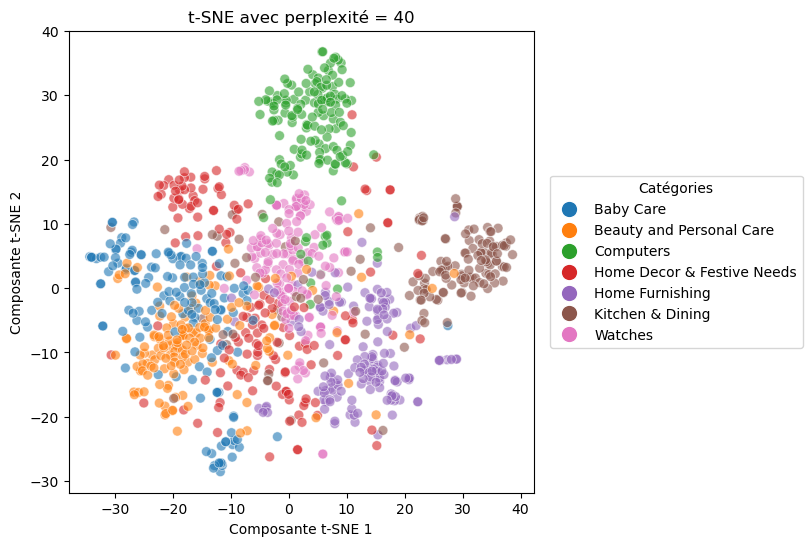

Applying t-SNE to ResNet50


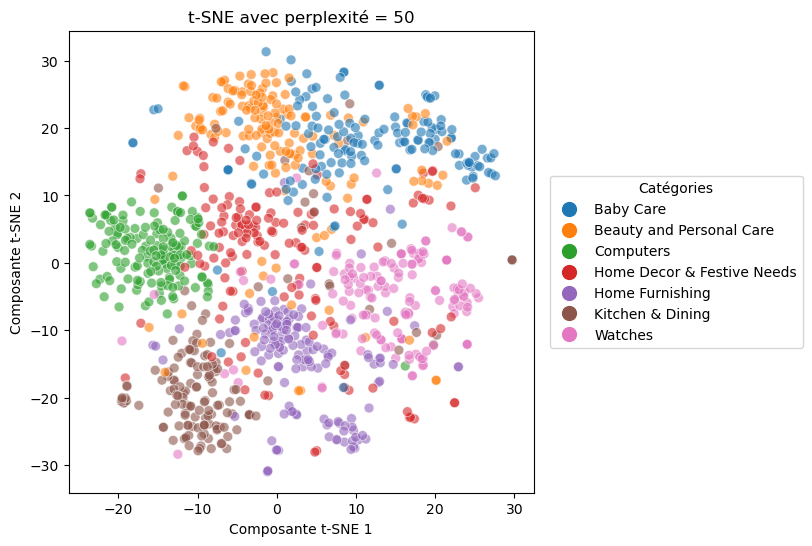

Applying t-SNE to InceptionV3


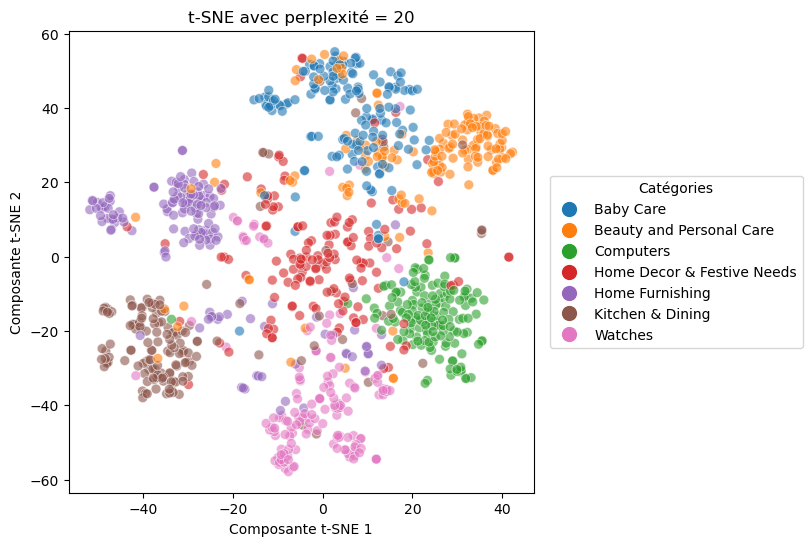

Applying t-SNE to InceptionResNetV2


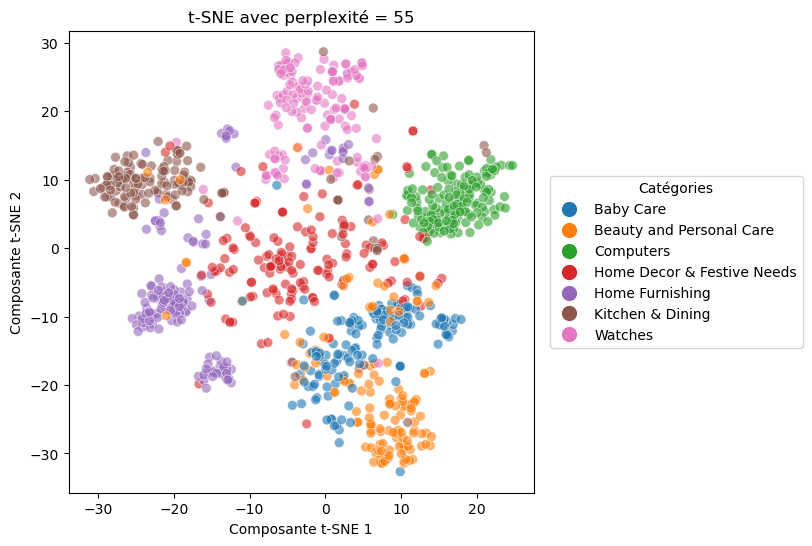

Applying t-SNE to DenseNet201


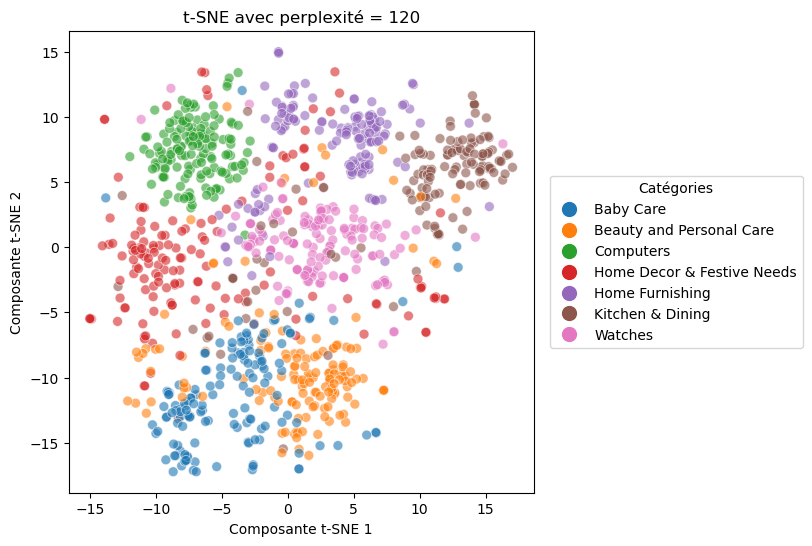

In [36]:
for model_name, df_pca in pca_results.items():
    pca_features = df_pca.copy()
    # Convertir les noms des colonnes en strings si nécessaire
    pca_features.columns = pca_features.columns.astype(str)
    print(f"Applying t-SNE to {model_name}")
    plot_tsne(pca_features, categories_encoded, category_names,perplexity=model_perplexities[model_name])

In [37]:
tsne_results = {}  # Dictionnaire pour stocker les résultats de t-SNE pour chaque modèle

for model_name, df_pca in pca_results.items():
    # Création de l'objet t-SNE avec la perplexité spécifique au modèle
    tsne = TSNE(n_components=2, perplexity=model_perplexities[model_name], random_state=42, n_iter=2000, init='random')
    
    # Application de t-SNE aux caractéristiques réduites par PCA
    tsne_results[model_name] = tsne.fit_transform(df_pca)
    
    print(f"t-SNE terminé pour {model_name} avec perplexité {model_perplexities[model_name]}")

t-SNE terminé pour VGG16 avec perplexité 40
t-SNE terminé pour ResNet50 avec perplexité 50
t-SNE terminé pour InceptionV3 avec perplexité 20
t-SNE terminé pour InceptionResNetV2 avec perplexité 55
t-SNE terminé pour DenseNet201 avec perplexité 120


## K-means

In [38]:
# Nombre de clusters
n_clusters = 7

### Sur SIFT

Silhouette Score: 0.3374
Adjusted Rand Score: 0.0520
Accuracy: 0.2724


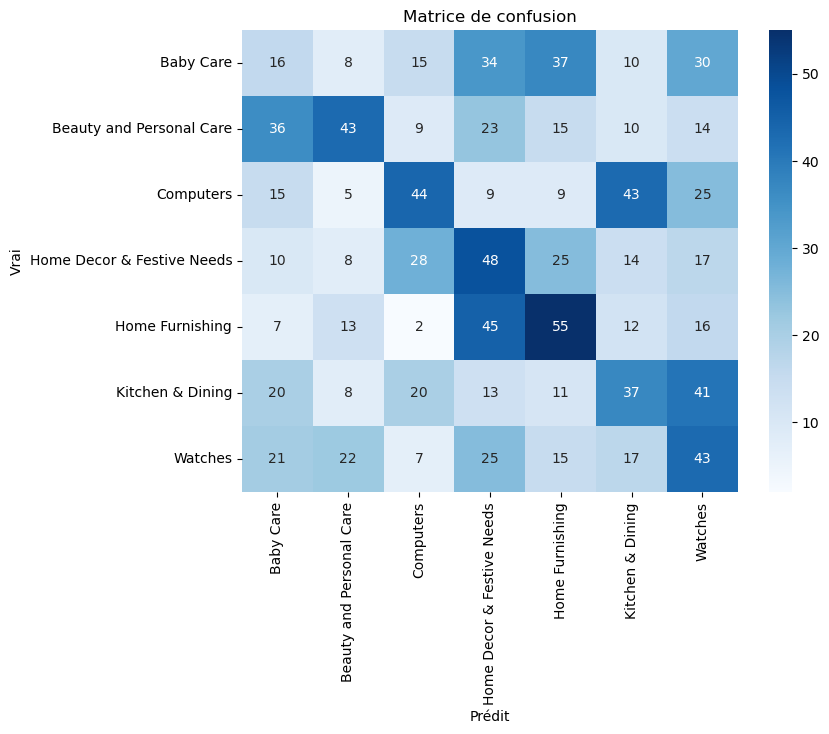

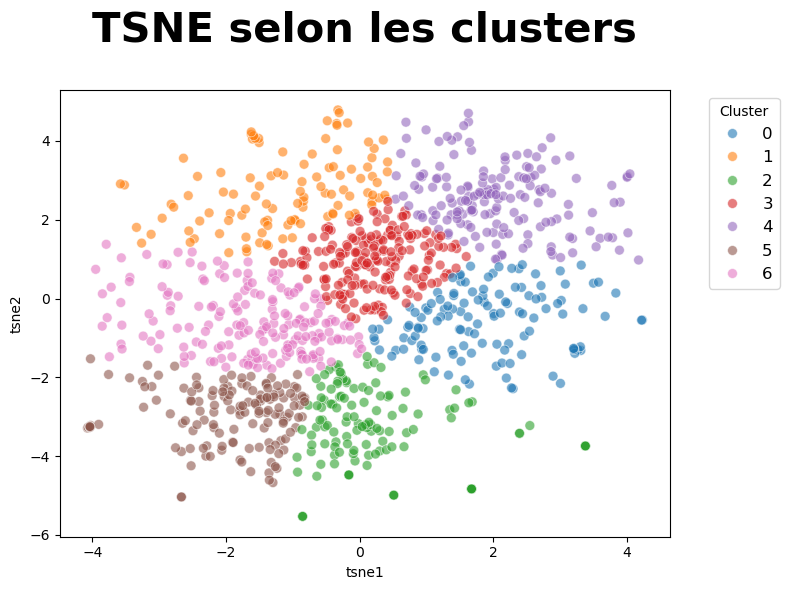

In [39]:
kmeans_metrics_sift = perform_kmeans(X_data=tsne_reduced_im_features, true_labels=categories_encoded, label_names=category_names,
                                n_clusters=n_clusters, random_state=42)

### Sur CNN

Applying K-means to t-SNE results of VGG16
Silhouette Score: 0.4257
Adjusted Rand Score: 0.4511
Accuracy: 0.6781


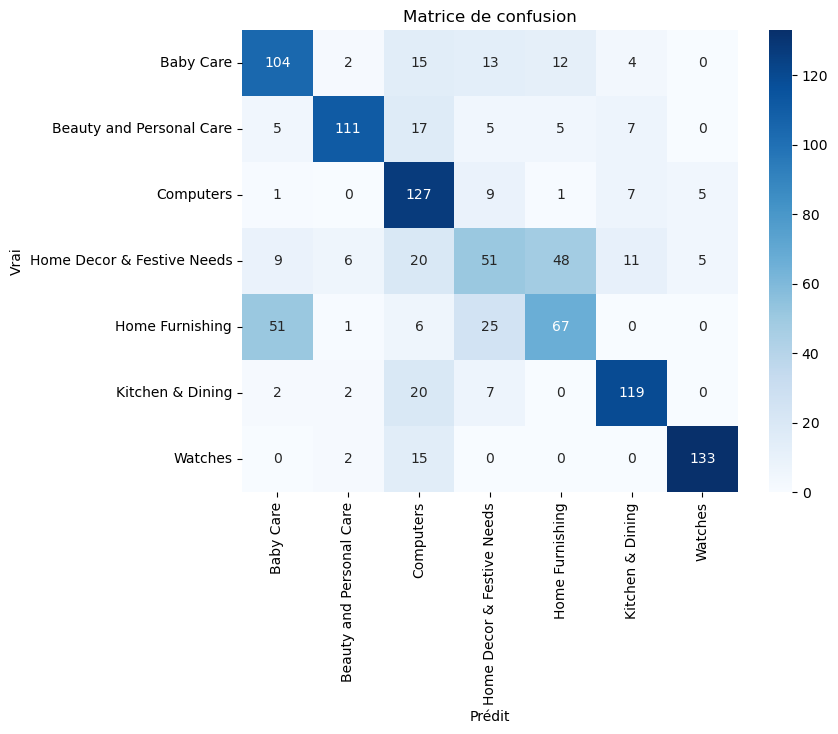

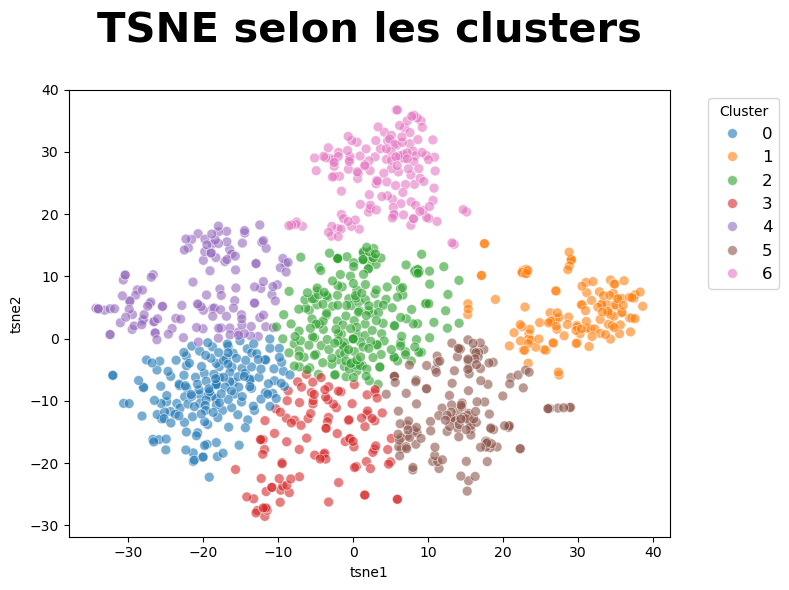

Applying K-means to t-SNE results of ResNet50
Silhouette Score: 0.4204
Adjusted Rand Score: 0.5406
Accuracy: 0.7495


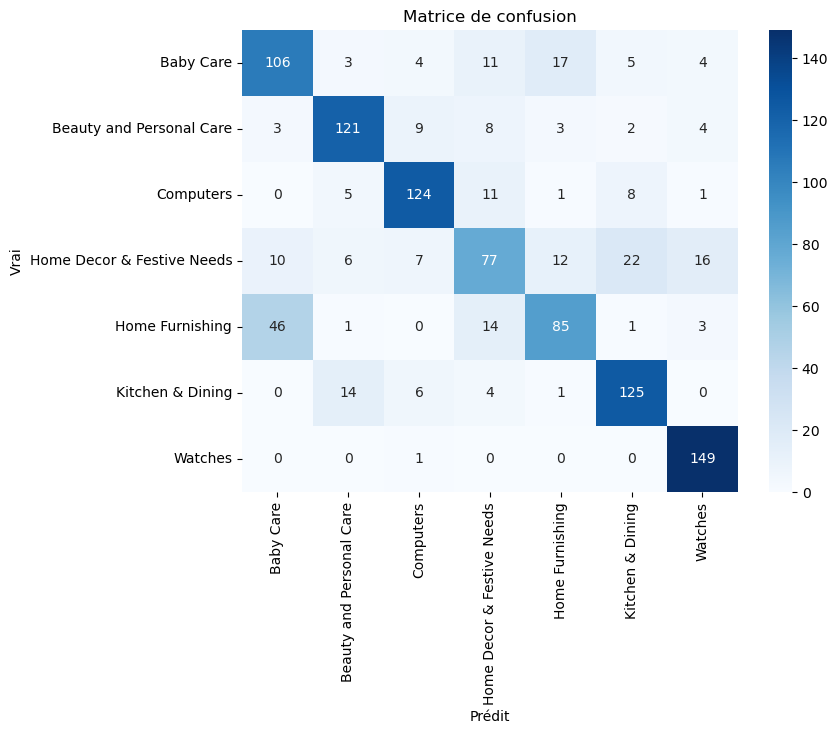

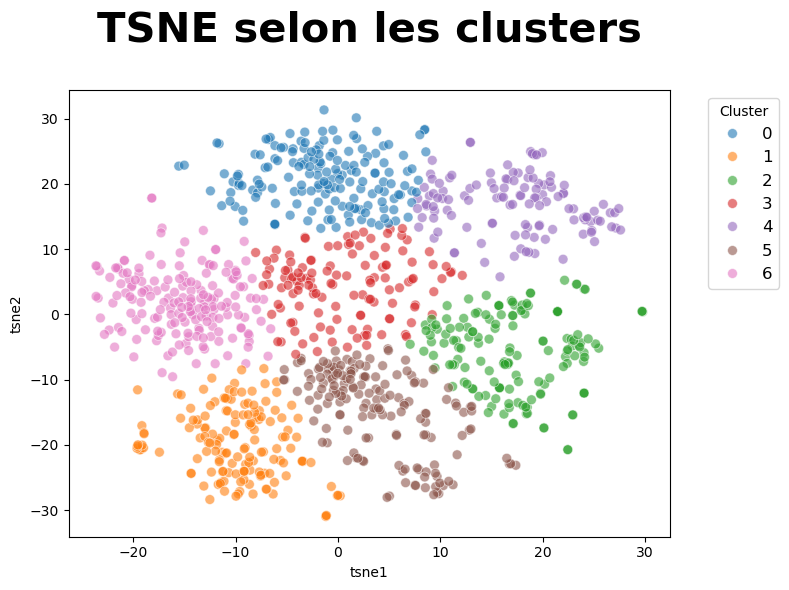

Applying K-means to t-SNE results of InceptionV3
Silhouette Score: 0.4837
Adjusted Rand Score: 0.5678
Accuracy: 0.7790


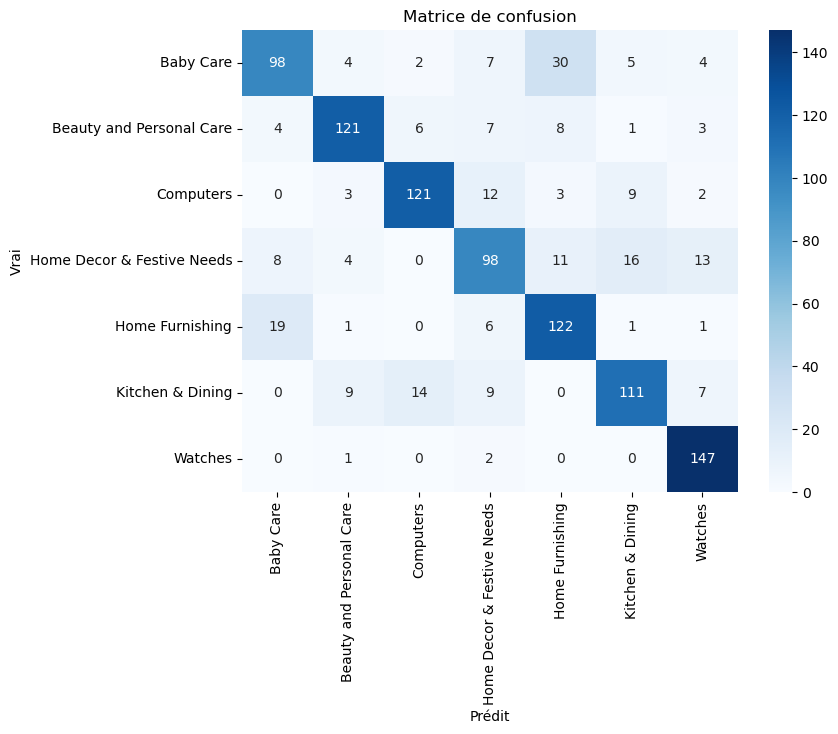

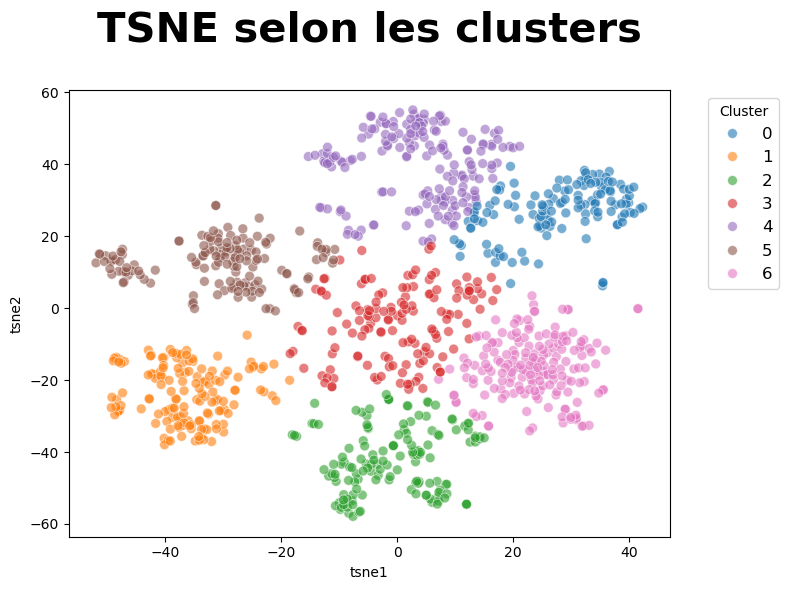

Applying K-means to t-SNE results of InceptionResNetV2
Silhouette Score: 0.5029
Adjusted Rand Score: 0.6008
Accuracy: 0.7829


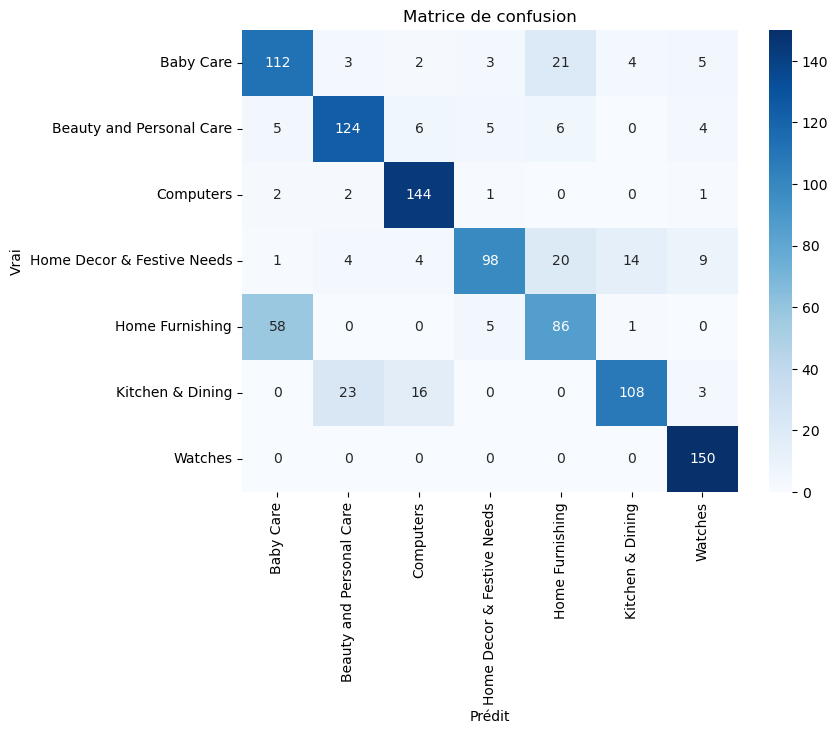

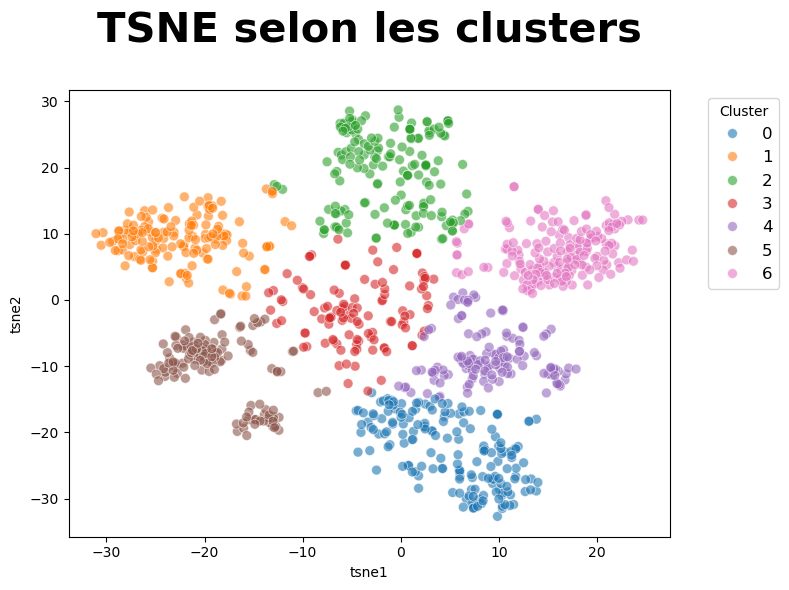

Applying K-means to t-SNE results of DenseNet201
Silhouette Score: 0.4339
Adjusted Rand Score: 0.5847
Accuracy: 0.7810


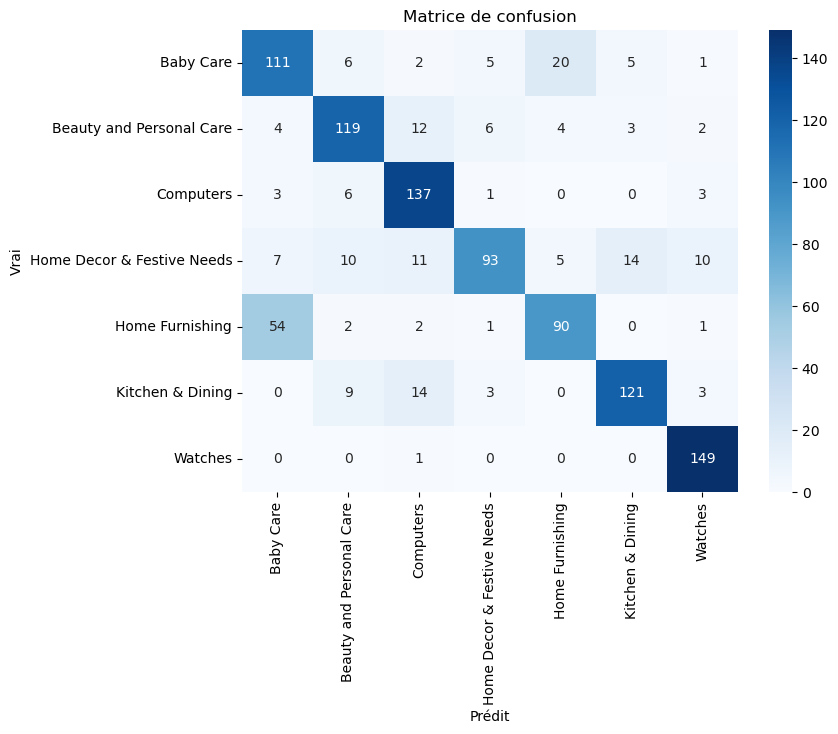

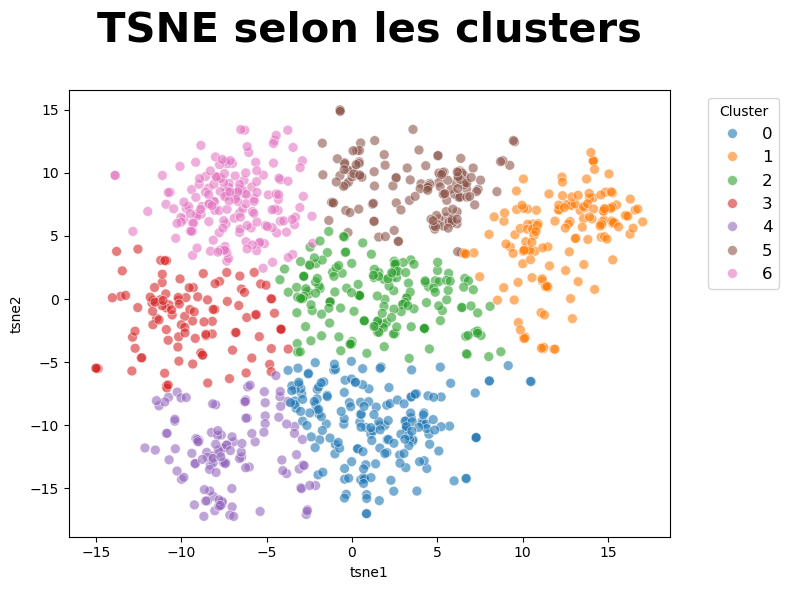

In [40]:
# Dictionnaire pour stocker les métriques de chaque modèle
kmeans_metrics = {}

for model_name, tsne_data in tsne_results.items():
    print(f"Applying K-means to t-SNE results of {model_name}")
    metrics = perform_kmeans(
        X_data=tsne_data, 
        true_labels=categories_encoded,
        label_names=category_names,
        n_clusters=n_clusters,
        random_state=42
    )
    
    # Stocker les métriques pour chaque modèle
    kmeans_metrics[model_name] = metrics

### Comparaison des résultats

In [41]:
# concaténation des resultats
all_metrics = {
    'SIFT': kmeans_metrics_sift,
    **kmeans_metrics
}

# Consolidation des données
data = []
for method, metrics_dict in all_metrics.items():
    for metric_name, value in metrics_dict.items():
        data.append({
            'Method': method,
            'Metric': metric_name,
            'Score': value
        })

data_metrics = pd.DataFrame(data)

In [42]:
data_metrics.head(5)

Method               Metric     Score
0   SIFT     Silhouette Score  0.337418
1   SIFT  Adjusted Rand Score  0.052005
2   SIFT             Accuracy  0.272381
3  VGG16     Silhouette Score  0.425668
4  VGG16  Adjusted Rand Score  0.451092

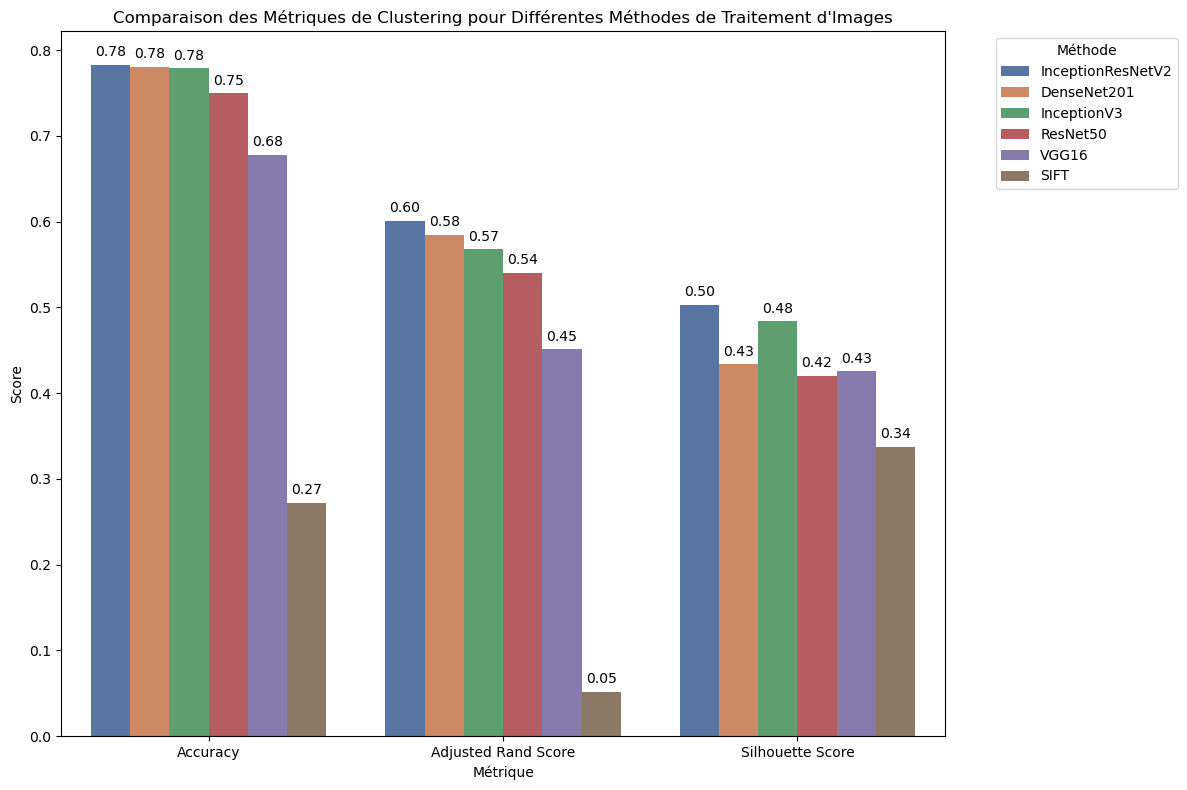

In [43]:
# Trier les données pour la visualisation
sorted_methods = data_metrics[data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)['Method'].unique()

# Assurer l'ordre des méthodes dans le DataFrame pour le graphique
data_metrics['Method'] = pd.Categorical(data_metrics['Method'], categories=sorted_methods, ordered=True)
data_metrics = data_metrics.sort_values('Method')

# Création du graphique
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=data_metrics, x='Metric', y='Score', hue='Method', palette='deep')

# Ajouter des valeurs de score sur les barres pour une meilleure lisibilité
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

# Configuration finale
plt.title('Comparaison des Métriques de Clustering pour Différentes Méthodes de Traitement d\'Images')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.legend(title='Méthode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Classification supervisée

In [44]:
def create_model_fct(base_model_name='VGG16'):
    """
    Crée et compile un modèle de classification d'images basé sur un modèle CNN pré-entraîné.
    
    Args:
    - base_model_name (str): Nom du modèle CNN pré-entraîné à utiliser.
    
    Returns:
    - model: Le modèle Keras compilé.
    """
    
    # Sélection du modèle de base en fonction du nom fourni
    if base_model_name == 'InceptionResNetV2':
        base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    elif base_model_name == 'DenseNet201':
        base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    elif base_model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(include_top=False, weights="imagenet", input_shape=(600, 600, 3))
    else:  # Le modèle par défaut est VGG16 si aucun nom valide n'est fourni
        base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # extraction des features
    for layer in base_model.layers:
        layer.trainable = False

    # Construction du modèle
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définition du nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    
    # Affichage du résumé du modèle
    #model.summary()
    
    return model

## Séparation des jeux de données (train, val, test)

In [45]:
y = to_categorical(categories_encoded, 7)

In [46]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [47]:
# Diviser les chemins d'image et les étiquettes
paths_train, paths_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, random_state=42)
paths_train, paths_val, y_train, y_val = train_test_split(paths_train, y_train, test_size=0.25, random_state=42)

In [48]:
y_test[:5]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [49]:
# Dictionnaire pour stocker les résultats
results = {}

## Evaluation des modèles sélectionnés

### VGG16

In [50]:
# Préparation des données
X_train_vgg16, X_val_vgg16, X_test_vgg16 = prepare_data(paths_train, paths_val, paths_test, preprocess_vgg16,
                                                        target_size=(224, 224, 3))

In [51]:
# Création du modèle
model_vgg16 = create_model_fct(base_model_name='VGG16')

In [52]:
# Entraînement du modèle
model_vgg16, history_vgg16, duration_vgg16 = train_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16, y_val,
                                                         model_save_path="./model_vgg16_best.weights.h5")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3378 - loss: 8.7378
Epoch 1: val_loss improved from inf to 1.68232, saving model to ./model_vgg16_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.3456 - loss: 8.5101 - val_accuracy: 0.6905 - val_loss: 1.6823
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6365 - loss: 2.4927
Epoch 2: val_loss improved from 1.68232 to 1.33669, saving model to ./model_vgg16_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.6383 - loss: 2.4717 - val_accuracy: 0.7571 - val_loss: 1.3367
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7188 - loss: 1.4105
Epoch 3: val_loss improved from 1.33669 to 1.28376, saving model to ./model_vgg16_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7206 - loss: 1.4033 - val_accuracy: 0.7571 - val_loss: 1.2838
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7633 - loss: 1.1155
Epoch 4: val_loss improved from 1

In [53]:
# Évaluation du modèle
loss_vgg16, accuracy_vgg16, ari_score_vgg16 = evaluate_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16,
                                                             y_val, X_test_vgg16, y_test, best_weights_path="./model_vgg16_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9991 - loss: 0.0096
Training Accuracy after last epoch: 0.9984

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8174 - loss: 0.8052
Test Accuracy after last epoch: 0.8143

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8159 - loss: 0.8176
Validation Accuracy (best): 0.8143
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8145 - loss: 0.6459
Test Accuracy (best): 0.8095
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Adjusted Rand Index (ARI): 0.6217


### InceptionResNetV2

In [54]:
# Préparation des données
X_train_inceptionresnetv2, X_val_inceptionresnetv2, X_test_inceptionresnetv2 = prepare_data(paths_train, paths_val,
                                                                                            paths_test, preprocess_inceptionresnetv2,
                                                                                            target_size=(299, 299, 3))

In [55]:
# Création du modèle
model_inceptionresnetv2 = create_model_fct(base_model_name='InceptionResNetV2')

In [56]:
# Entraînement du modèle
model_iresnetv2, history_iressnetv2, duration_iresnetv2 = train_model(model_inceptionresnetv2, X_train_inceptionresnetv2,
                                                                      y_train, X_val_inceptionresnetv2, y_val,
                                                                      model_save_path="./model_inceptionresnetv2_best.weights.h5")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3552 - loss: 1.9218
Epoch 1: val_loss improved from inf to 0.69755, saving model to ./model_inceptionresnetv2_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.3699 - loss: 1.8874 - val_accuracy: 0.7762 - val_loss: 0.6975
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7801 - loss: 0.7586
Epoch 2: val_loss improved from 0.69755 to 0.52329, saving model to ./model_inceptionresnetv2_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.7816 - loss: 0.7538 - val_accuracy: 0.8381 - val_loss: 0.5233
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8781 - loss: 0.4724
Epoch 3: val_loss improved from 0.52329 to 0.48878, saving model to ./model_inceptionresnetv2_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.8751 - loss: 0.4803 - val_accuracy: 0.7952 - val_loss: 0.4888
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8490 - loss: 0.54

In [57]:
# Évaluation du modèle
loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2 = evaluate_model(model_inceptionresnetv2,
                                                                                                 X_train_inceptionresnetv2,
                                                                                                 y_train, X_val_inceptionresnetv2,
                                                                                                 y_val, X_test_inceptionresnetv2,
                                                                                                 y_test,
                                                                                                 best_weights_path="./model_inceptionresnetv2_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9868 - loss: 0.0411
Training Accuracy after last epoch: 0.9857

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9081 - loss: 0.4286
Test Accuracy after last epoch: 0.8905

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8741 - loss: 0.3708
Validation Accuracy (best): 0.8810
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8943 - loss: 0.4220
Test Accuracy (best): 0.8905
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Adjusted Rand Index (ARI): 0.7818


### DenseNet201

In [58]:
# Préparation des données
X_train_densenet201, X_val_densenet201, X_test_densenet201 = prepare_data(paths_train, paths_val, paths_test,
                                                                          preprocess_densenet201, target_size=(224, 224, 3))


In [59]:
# Création du modèle
model_densenet201 = create_model_fct(base_model_name='DenseNet201')


In [60]:
# Entraînement du modèle
model_densenet201, history_densenet201, duration_densenet201 = train_model(model_densenet201, X_train_densenet201, y_train,
                                                                           X_val_densenet201, y_val,
                                                                           model_save_path="./model_densenet201_best.weights.h5")


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2815 - loss: 2.4530
Epoch 1: val_loss improved from inf to 0.71123, saving model to ./model_densenet201_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - accuracy: 0.2988 - loss: 2.3969 - val_accuracy: 0.7905 - val_loss: 0.7112
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7689 - loss: 0.7419
Epoch 2: val_loss improved from 0.71123 to 0.66871, saving model to ./model_densenet201_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7699 - loss: 0.7393 - val_accuracy: 0.7714 - val_loss: 0.6687
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8101 - loss: 0.5576
Epoch 3: val_loss improved from 0.66871 to 0.60646, saving model to ./model_densenet201_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8106 - loss: 0.5561 - val_accuracy: 0.8000 - val_loss: 0.6065
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9131 - loss: 0.3918
Epoch 4: val_lo

In [61]:
# Évaluation du modèle
loss_densenet201, accuracy_densenet201, ari_score_densenet201 = evaluate_model(model_densenet201, X_train_densenet201,
                                                                               y_train, X_val_densenet201,
                                                                                y_val, X_test_densenet201, y_test,
                                                                               best_weights_path="./model_densenet201_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9966 - loss: 0.0296
Training Accuracy after last epoch: 0.9968

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8744 - loss: 0.4421
Test Accuracy after last epoch: 0.8571

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8274 - loss: 0.4889
Validation Accuracy (best): 0.8429
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8813 - loss: 0.3970
Test Accuracy (best): 0.8667
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Adjusted Rand Index (ARI): 0.7298


### Comparaison des résultats

In [88]:
# Initialisation de la liste pour stocker les résultats
data_results = []

# Fonction pour ajouter les résultats d'un modèle au DataFrame
def add_results(model_name, loss, accuracy, ari_score, duration):
    metrics = ['Loss', 'Accuracy', 'Adjusted Rand Score', 'Duration (en heures)']
    scores = [loss, accuracy, ari_score, (duration/3600)]
    for metric, score in zip(metrics, scores):
        data_results.append({
            'Model': model_name,
            'Metric': metric,
            'Score': score
        })

In [89]:
add_results('VGG16', loss_vgg16, accuracy_vgg16, ari_score_vgg16, duration_vgg16)
add_results('InceptionResNetV2', loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2, duration_iresnetv2)
add_results('DenseNet201', loss_densenet201, accuracy_densenet201, ari_score_densenet201, duration_densenet201)

data_metrics = pd.DataFrame(data_results)

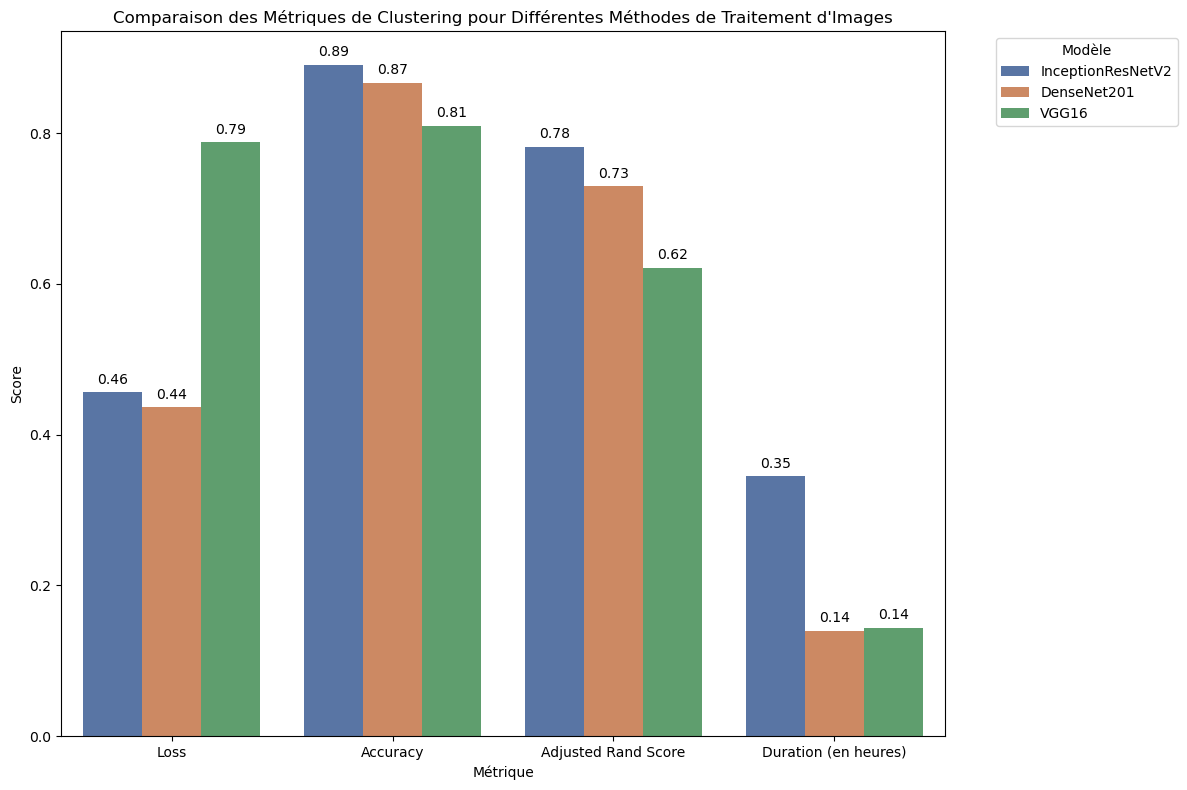

In [90]:
# Trier les données pour la visualisation
sorted_methods = data_metrics[data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)['Model'].unique()

# Assurer l'ordre des méthodes dans le DataFrame pour le graphique
data_metrics['Model'] = pd.Categorical(data_metrics['Model'], categories=sorted_methods, ordered=True)
data_metrics = data_metrics.sort_values('Model')

# Création du graphique
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=data_metrics, x='Metric', y='Score', hue='Model', palette='deep')

# Ajouter des valeurs de score sur les barres pour une meilleure lisibilité
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

# Configuration finale
plt.title('Comparaison des Métriques de Clustering pour Différentes Méthodes de Traitement d\'Images')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.legend(title='Modèle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optimisation (Hyper paramètres)

In [91]:
# Entraînement du modèle
bestmodel = train_model_with_search(model_inceptionresnetv2, X_train_inceptionresnetv2, y_train, X_val_inceptionresnetv2, y_val,
                                    model_save_path="./model_best.weights.h5")

TypeError: train_model_with_search() got multiple values for argument 'model_save_path'

In [ ]:
# Évaluation du modèle
loss_best, accuracy_best, ari_score_best = evaluate_model(bestmodel,
                                                          X_train_inceptionresnetv2,
                                                          y_train, X_val_inceptionresnetv2,
                                                          y_val, X_test_inceptionresnetv2,
                                                          y_test, best_weights_path="none")